<a href="https://colab.research.google.com/github/lIlIlIIIlIIl/DeepLearning_Basic/blob/main/Unet_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 18.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 44.7 MB/s eta 0:00:0000:01:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.8 MB/s eta 0:00:00:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install torch torchvision torchaudio

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

In [ ]:
import zipfile
zip_file = zipfile.ZipFile('./dataset.zip') # 압축을 해제할 '/파일경로/파일명.zip'
zip_file.extractall('./') # 압축을 해제할 '/위치경로/'

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import numpy as np

# 커스텀 데이터셋 클래스
class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_names = os.listdir(image_dir)  # 이미지 파일 리스트

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        # 이미지와 마스크 파일 이름 설정
        name = self.image_names[idx]
        # 이미지와 마스크 파일 경로
        img_path = os.path.join(self.image_dir, name)
        mask_path = os.path.join(self.mask_dir, name)

        # 이미지와 마스크 로드 (1채널로 변환)
        image = Image.open(img_path).convert("L")  # 1채널 흑백 이미지로 변환
        mask = Image.open(mask_path).convert("L")  # 마스크도 1채널로 변환

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# 이미지와 마스크 폴더 경로
image_dir = "./dataset/images"
mask_dir = "./dataset/label"

transform = transforms.Compose([
    transforms.Resize((512, 512)),  # 이미지 크기 조정: 512x512
    transforms.ToTensor()  # 텐서로 변환 (1채널의 경우 ToTensor는 [1, H, W] 형식으로 만듭니다)
])
# 전체 데이터셋 로드
dataset = ImageMaskDataset(image_dir=image_dir, mask_dir=mask_dir, transform=transform)

# 전체 데이터셋을 train, validation, test로 분할 (예시: 70%, 15%, 15%)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# 데이터 로더 생성 (train, validation, test)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# 데이터 확인
for images, masks in train_loader:
    print(f'Image batch size: {images.size()}')  # [8, 1, 512, 512] -> 1채널
    print(f'Mask batch size: {masks.size()}')  # [8, 1, 512, 512] -> 1채널
    break


Image batch size: torch.Size([4, 1, 512, 512])
Mask batch size: torch.Size([4, 1, 512, 512])


In [ ]:
def conv3x3(in_planes, out_planes, stride=1, padding=0):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=padding, bias=False)

def conv1x1(in_planes, out_planes, stride=1, padding=0):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                     bias=False)

In [ ]:
import torch.nn.functional as F

def conv3x3(in_channels, out_channels, stride=1, padding=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding, bias=False)

def conv1x1(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()

        def Block(in_channels, out_channels, stride=1, padding=1):
            return nn.Sequential(
                conv3x3(in_channels, out_channels, stride=stride, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            )

        # ===== contracting path ===== #
        self.conv1 = nn.Sequential(Block(1, 64), Block(64, 64))
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Sequential(Block(64, 128), Block(128, 128))
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Sequential(Block(128, 256), Block(256, 256))
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Sequential(Block(256, 512), Block(512, 512))
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Sequential(Block(512, 1024), Block(1024, 1024))

        # ===== expansive path ===== #
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = nn.Sequential(Block(1024, 512), Block(512, 512))

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = nn.Sequential(Block(512, 256), Block(256, 256))

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = nn.Sequential(Block(256, 128), Block(128, 128))

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = nn.Sequential(Block(128, 64), Block(64, 64))

        self.conv10 = conv1x1(64, 1)

    def forward(self, x):
        # contracting path
        x = self.conv1(x)
        identity1 = x  # skip connection
        x = self.maxpool1(x)

        x = self.conv2(x)
        identity2 = x
        x = self.maxpool2(x)

        x = self.conv3(x)
        identity3 = x
        x = self.maxpool3(x)

        x = self.conv4(x)
        identity4 = x
        x = self.maxpool4(x)

        x = self.conv5(x)

        # expansive path
        x = self.upconv1(x)
        identity4_cropped = F.interpolate(identity4, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=True)
        x = torch.cat((identity4_cropped, x), dim=1)
        x = self.conv6(x)

        x = self.upconv2(x)
        identity3_cropped = F.interpolate(identity3, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=True)
        x = torch.cat((identity3_cropped, x), dim=1)
        x = self.conv7(x)

        x = self.upconv3(x)
        identity2_cropped = F.interpolate(identity2, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=True)
        x = torch.cat((identity2_cropped, x), dim=1)
        x = self.conv8(x)

        x = self.upconv4(x)
        identity1_cropped = F.interpolate(identity1, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=True)
        x = torch.cat((identity1_cropped, x), dim=1)
        x = self.conv9(x)

        x = self.conv10(x)

        return x

In [ ]:
def train_model(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct_pixels = 0
    total_pixels = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)

        # 이진 마스크로 변환 (0.5 기준)
        predicted_masks = (outputs > 0.5).float()

        # Loss 계산
        loss = criterion(outputs, masks)

        # 정확도 계산
        correct_pixels += (predicted_masks == masks).sum().item()
        total_pixels += masks.numel()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    accuracy = 100 * correct_pixels / total_pixels

    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:2.2f}")

    return model, epoch_loss, accuracy

In [ ]:
# 검증 루틴 설정
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct_pixels = 0
    total_pixels = 0
    with torch.no_grad():
        for images, masks in val_loader:

            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)

            predicted_masks = (outputs > 0.5).float()

            loss = criterion(outputs, masks)

            correct_pixels += (predicted_masks == masks).sum().item()
            total_pixels += masks.numel()

            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    accuracy = 100 * correct_pixels / total_pixels
    print(f"Val Loss: {val_loss:.4f} Val Accuracy: {accuracy:2.2f}")
    return val_loss, accuracy

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(results):
    epochs = range(1, len(results['train_losses']) + 1)

    # 손실(Loss) 시각화
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, results['train_losses'], label='Train Loss')
    plt.plot(epochs, results['val_losses'], label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 정확도(Accuracy) 시각화
    plt.subplot(1, 2, 2)
    plt.plot(epochs, results['train_accs'], label='Train Accuracy')
    plt.plot(epochs, results['val_accs'], label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 그래프 출력
    plt.tight_layout()
    plt.show()

In [ ]:
def save_model(model, path='unet_model.pth'):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

In [ ]:
# IoU 계산 함수
def calculate_iou(pred, true):
    pred = pred > 0.5  # 이진화
    true = true > 0.5

    intersection = (pred & true).float().sum().item()  # 교집합
    union = (pred | true).float().sum().item()  # 합집합

    iou = intersection / union if union != 0 else 0
    return iou

# Dice 계수 계산 함수
def calculate_dice(pred, true):
    pred = pred > 0.5  # 이진화
    true = true > 0.5

    intersection = (pred & true).float().sum().item()  # 교집합

    dice = (2. * intersection) / (pred.float().sum().item() + true.float().sum().item())
    return dice

# 성능 평가 함수 (IoU, Dice 포함)
def evaluate_model(model, data_loader):
    model.eval()  # 모델을 평가 모드로 전환
    total_iou = 0.0
    total_dice = 0.0
    total_correct_pixels = 0
    total_pixels = 0
    total_samples = 0

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for images, masks in data_loader:
            images = images.to(device)
            masks = masks.to(device)

            # 모델 출력
            outputs = model(images)
            predicted_masks = (outputs > 0.5).float()

            # 정확도 계산 (모든 픽셀 비교)
            correct_pixels = (predicted_masks == masks).sum().item()
            total_correct_pixels += correct_pixels
            total_pixels += masks.numel()

            # IoU 계산
            for pred, true in zip(predicted_masks, masks):
                total_iou += calculate_iou(pred, true)

            # Dice 계산
            for pred, true in zip(predicted_masks, masks):
                total_dice += calculate_dice(pred, true)

            total_samples += images.size(0)

    # 평균 성능 지표
    avg_accuracy = 100 * total_correct_pixels / total_pixels  # 정확도 계산을 전체 픽셀 수 기준으로
    avg_iou = total_iou / total_samples
    avg_dice = total_dice / total_samples

    print(f"Avg Accuracy: {avg_accuracy:.2f}%, Avg IoU: {avg_iou:.4f}, Avg Dice: {avg_dice:.4f}")

Epoch 1/30
Train Loss: 0.6170, Train Accuracy: 42.18
Val Loss: 0.6773 Val Accuracy: 21.81
Epoch 2/30
Train Loss: 0.5161, Train Accuracy: 67.65
Val Loss: 0.6422 Val Accuracy: 21.81
Epoch 3/30
Train Loss: 0.4568, Train Accuracy: 74.92
Val Loss: 0.5789 Val Accuracy: 32.57
Epoch 4/30
Train Loss: 0.4087, Train Accuracy: 80.42
Val Loss: 0.5295 Val Accuracy: 83.45
Epoch 5/30
Train Loss: 0.3823, Train Accuracy: 82.88
Val Loss: 0.4902 Val Accuracy: 83.42
Epoch 6/30
Train Loss: 0.3633, Train Accuracy: 84.93
Val Loss: 0.4656 Val Accuracy: 82.34
Epoch 7/30
Train Loss: 0.3526, Train Accuracy: 86.56
Val Loss: 0.3865 Val Accuracy: 87.40
Epoch 8/30
Train Loss: 0.3406, Train Accuracy: 88.29
Val Loss: 0.3857 Val Accuracy: 87.61
Epoch 9/30
Train Loss: 0.3267, Train Accuracy: 88.18
Val Loss: 0.3268 Val Accuracy: 89.90
Epoch 10/30
Train Loss: 0.3186, Train Accuracy: 88.85
Val Loss: 0.3314 Val Accuracy: 88.98
Epoch 11/30
Train Loss: 0.3078, Train Accuracy: 89.66
Val Loss: 0.3177 Val Accuracy: 90.46
Epoch 12

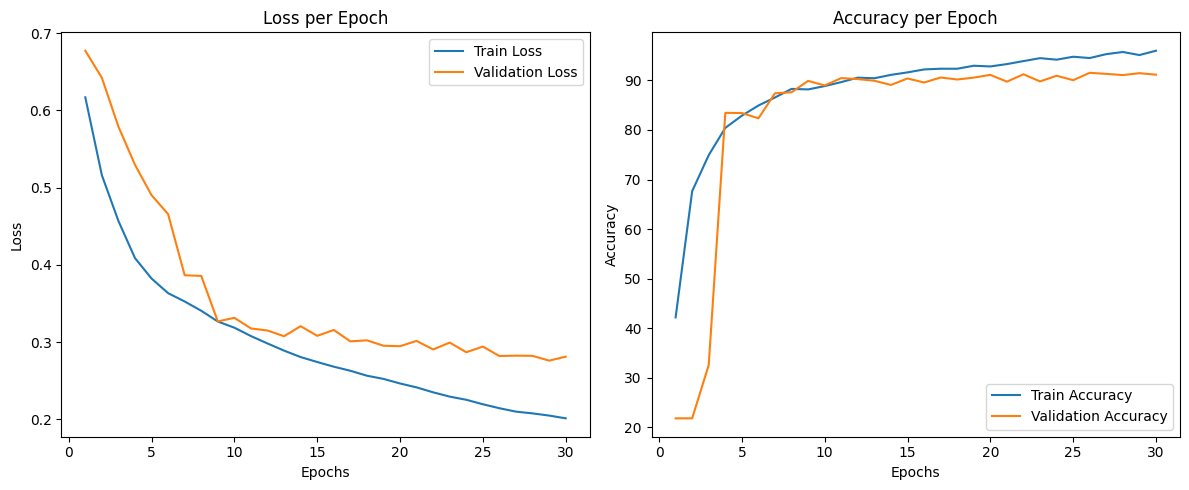

Model saved to unet_trained_model.pth


In [ ]:
# 모델 설정
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

train_losses = []
val_losses = []
train_accs = []
val_accs = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Unet()
model = model.to(device)

# 손실 함수와 옵티마이저 설정
criterion = nn.BCEWithLogitsLoss()  # 이진 마스크에 대한 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0001)

# 학습 및 검증 실행
num_epochs = 30
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model, train_loss, train_acc = train_model(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate_model(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

evaluate_model(model, test_loader)

result = {}
result['train_losses'] = train_losses
result['val_losses'] = val_losses
result['train_accs'] = train_accs
result['val_accs'] = val_accs

plot_metrics(result)
save_model(model, 'unet_trained_model.pth')



/tmp/ipykernel_423/904170618.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


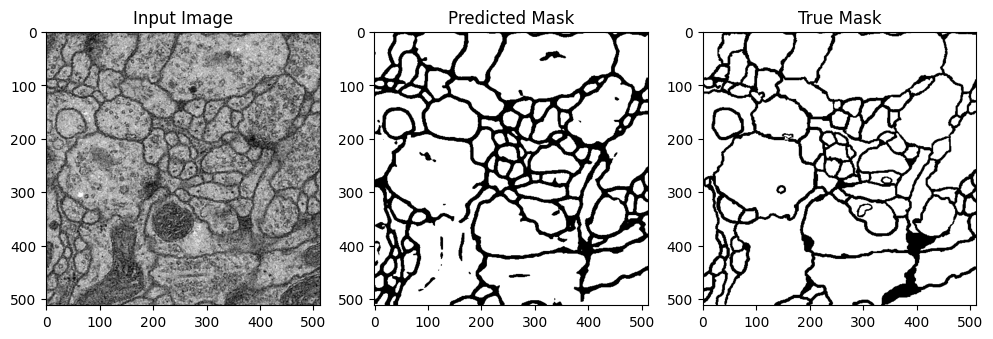

Avg Accuracy: 90.97%, Avg IoU: 0.8882, Avg Dice: 0.9408


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# 모델 로드
def load_model(path='unet_trained_model.pth'):
    model = Unet()  # Unet 모델 정의
    model.load_state_dict(torch.load(path))
    model.eval()  # 평가 모드로 전환
    return model

# 예측 및 시각화 함수
def visualize_prediction(model, test_image, true_mask=None):
    model.eval()  # 모델을 평가 모드로 전환
    with torch.no_grad():  # 그래디언트 계산 비활성화
        # 이미지 예측
        test_image = test_image.unsqueeze(0).to(device)  # 배치 크기 추가
        output = model(test_image)
        predicted_mask = (output > 0.5).float().squeeze(0).cpu().numpy()  # 이진화 후 CPU로 전송

    # 시각화
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # 원본 이미지 시각화
    axs[0].imshow(test_image.squeeze(0).cpu().permute(1, 2, 0), cmap='gray')
    axs[0].set_title('Input Image')

    # 예측된 마스크 시각화
    axs[1].imshow(predicted_mask.squeeze(), cmap='gray')
    axs[1].set_title('Predicted Mask')

    # 실제 마스크 시각화 (있을 경우)
    if true_mask is not None:
        axs[2].imshow(true_mask.squeeze(), cmap='gray')
        axs[2].set_title('True Mask')

    plt.show()

# 모델 불러오기 및 테스트 이미지 시각화
model = load_model('unet_trained_model.pth')
model.cuda()

# 테스트 데이터에서 이미지와 마스크 가져오기 (예: 첫 번째 이미지)
test_image, true_mask = next(iter(test_loader))

visualize_prediction(model, test_image[0], true_mask[0])

# 모델 평가
evaluate_model(model, test_loader)